# Can the codon frequency be used to predict the DNAtype and Kingdom? This time using Deep Learning.
---
<b>MADS-DL Portfolio-Exam Part 2<br>
Janosch Höfer, 938969</b>

## Table of contents

- [Introduction](#intro) <br>
- [1. Data preparation](#data-prep) <br>
- [2. Parameters](#parameters) <br>
- [3. Split Data](#split) <br>
- [4. Model setup and Hyperparameter Optimization](#model-setup) <br>
   - [4.1. Neural Network](#NN) <br>
   - [4.2. Cross-validation](#CV) <br>
- [5. Model Evaluation](#eval) <br>
   - [5.1. Codon-Kingdom](#eval-king) <br>
   - [5.2. Codon-DNAtype](#eval-dna) <br>
- [6. Result](#result)<br>
    - [6.1 Results-Kingdom](#res-king)<br>
    - [6.2 Results-DNAtype](#res-dna)<br>
    - [6.3 Discussion](#dis)<br>
- [References](#ref)<br>

## Introduction

In the last semester we have investigated the application of different Machine Learning algorithms to predict the DNAtype and Kingdom given the Codon frequencies. We did show that although some algorithms were not applicable, k-Nearest neighbor and Random Forest were able to make accurate predictions. The dataset we used then was the <b>Codon usage</b> dataset that had been downloaded from the UCI Machine Learning Repository <a href='https://archive.ics.uci.edu/ml/datasets/Codon+usage'>[1]</a>. We validated Khomtchouk BB. approach <a href='https://www.biorxiv.org/content/10.1101/2020.10.26.356295v1.full.pdf'>[2]</a> and confirmed his results. Now we want to solve the same problem using sophisticated Deep Learning Neural Networks and explore where these outperform the classical Machine Learning models and where they might have some shortcomings.<br>
<br>
<b>DISCLAIMER: This notebook trains the final two models live. In total they required 70-90 minutes of training time.</b>

In [1]:
# Standard libraries
import copy
import logging
import os
import pickle
import random
from datetime import timedelta
from timeit import default_timer as timer

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psutil
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn.functional as F
from IPython.display import Image
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight

# Own classes and functions
from neuralnet import NeuralNet, load_best_model
from utils import DataModule, compute_metrics, plot_multi_conf

For our networks we will be using Pytorch Lightning. Pytorch Lightning is a high-level interface for PyTorch, which goal is to make Deep Learning (DL) faster to develop and more scalable [[3]](https://www.pytorchlightning.ai/). Once we start with the Hyperparameter optimization, we will take a look at how it differs from the typical PyTorch workflow. Before we start we set all seeds and define on which devices our computations are run. 

In [2]:
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)
RANDOM_SEED = 42
pl.seed_everything(RANDOM_SEED, workers=True)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
device

device(type='cpu')

Before we continue with our experiments we first use the Machine Learning results from last time as our baseline. For the kingdoms k-Nearest Neighbor (KNN) and Random Forest (RF) achieved very good results. The Balanced Accuracy for KNN was at an impressive 1.0 and for Random Forest at 0.74. The Confusion Matrices below show that KNN was even able to predict underrepresented classes. Because the baseline for the kingdoms is unbeatable, we will just try to achieve the same results. 

In [3]:
ml_king = pd.read_parquet("data/ml_king", engine="pyarrow")
ml_king

,Accuracy,Balanced Accuracy,Recall,ROC AUC,Time Training,Time Predicting
Model,,,,,,
k-Nearest Neighbor,1.0000,1.0000,1.0000,1.0000,0.002773,0.286271
Random Forest,0.9660,0.7418,0.9660,0.9979,4.113501,0.060584
Naive Bayes,0.5072,0.2369,0.5072,0.8371,0.005549,0.001122


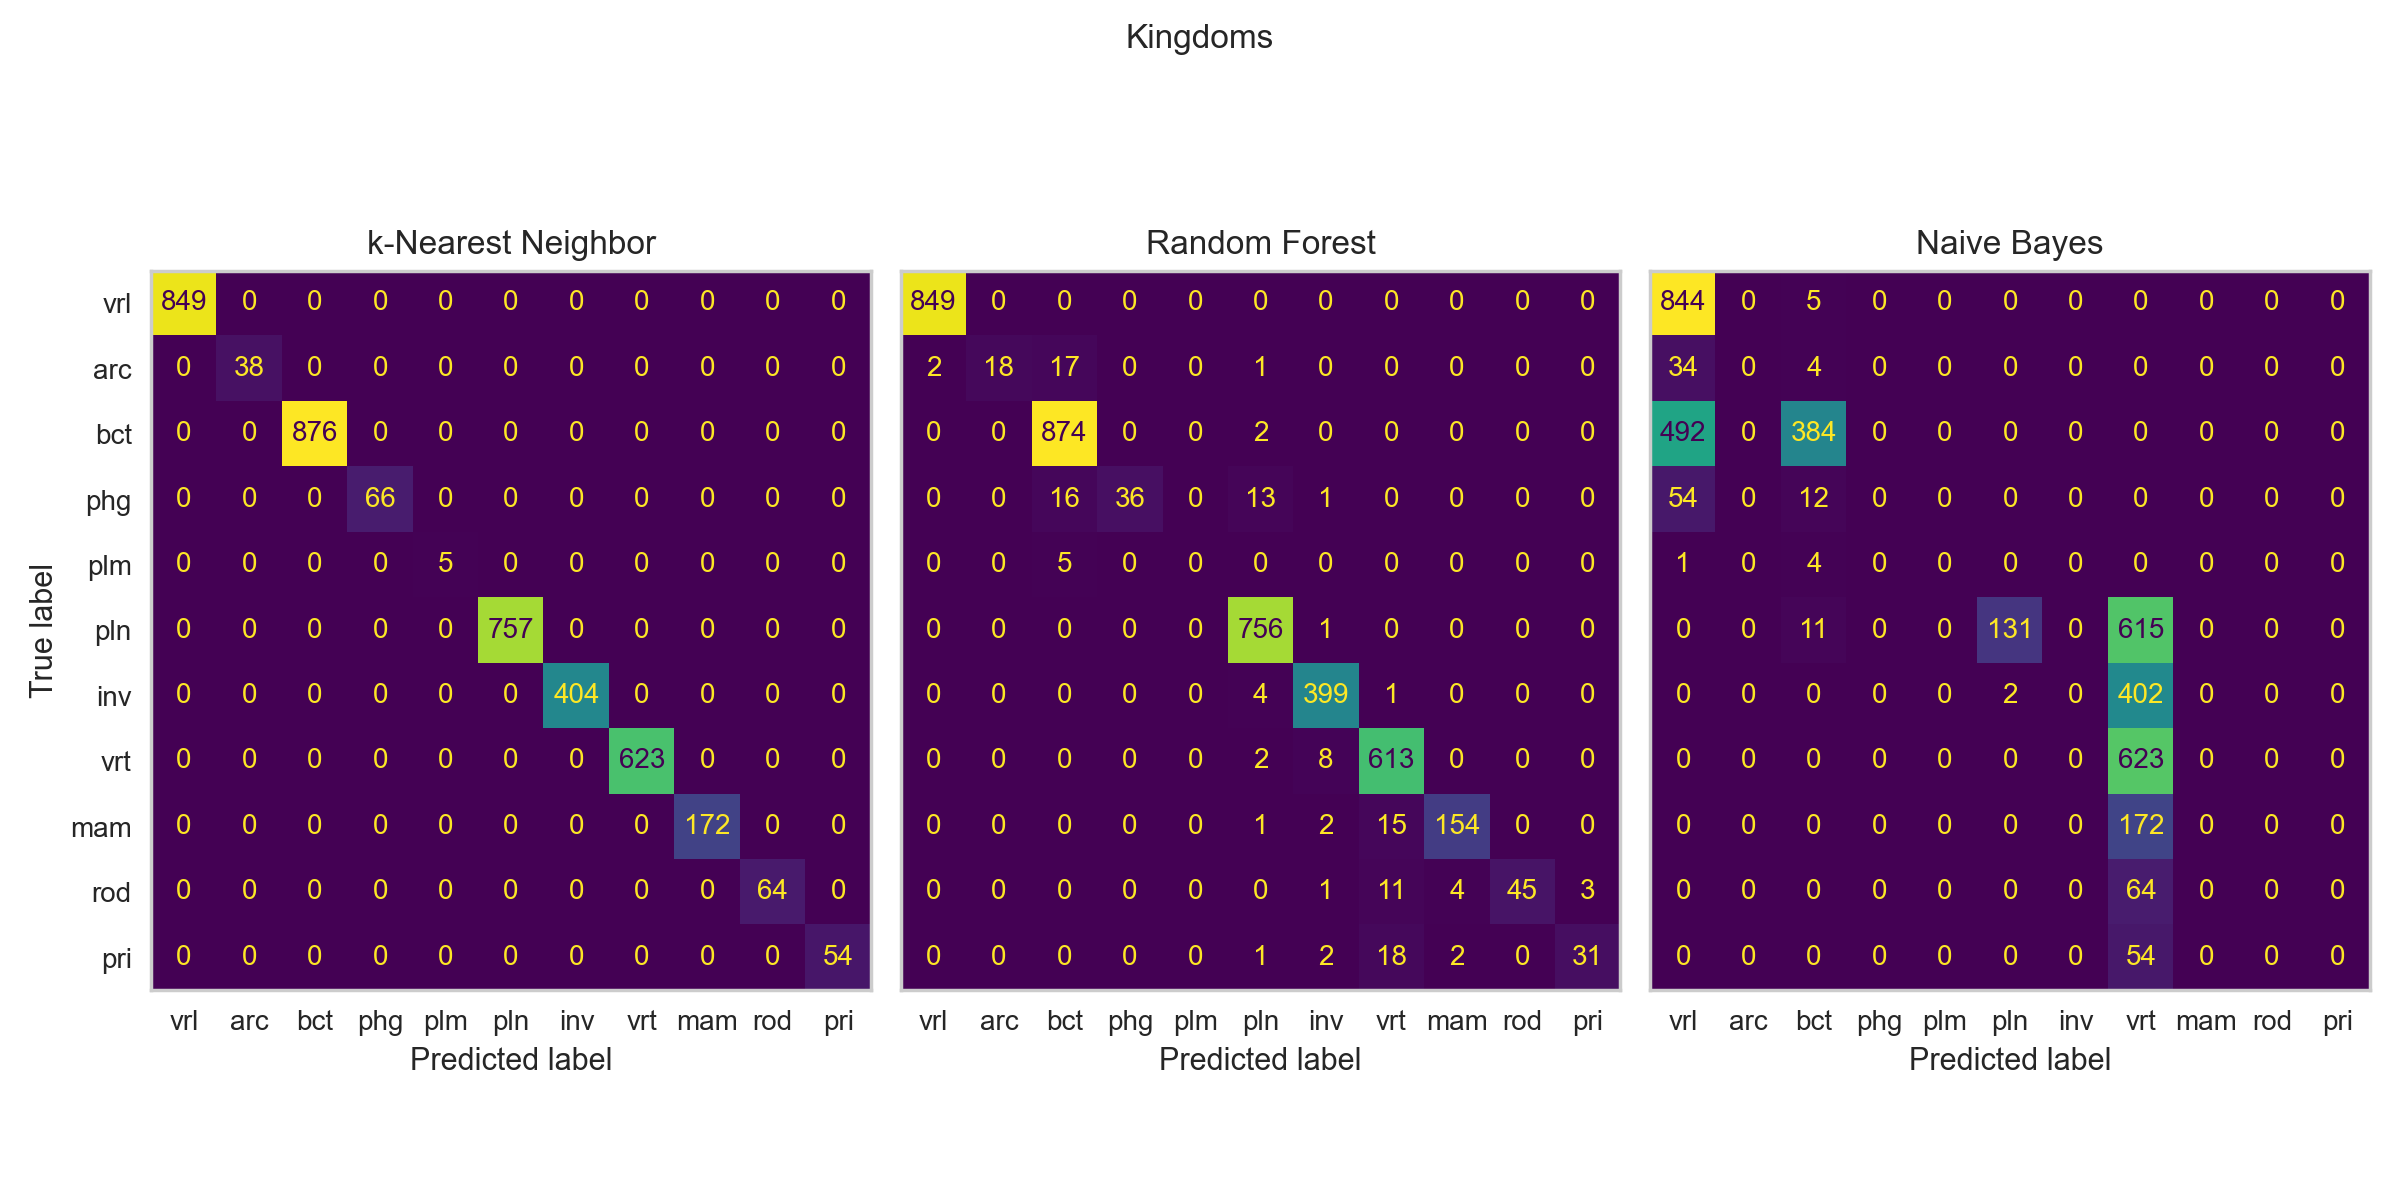

In [4]:
Image(filename="data/king_plot.png")

Although the results for the DNA types were not as good, they were still very impressive. The Balanced Accuracy for KNN was 0.85 and for RF 0.77. All models struggled with the underrepresented classes. Because these metrics are not as perfect as those for the kingdoms we will try to beat them with our DL models.

In [5]:
ml_dna = pd.read_parquet("data/ml_dna", engine="pyarrow")
ml_dna

,Accuracy,Balanced Accuracy,Recall,ROC AUC,Time Training,Time Predicting
Model,,,,,,
k-Nearest Neighbor,0.9926,0.8505,0.9926,0.9402,0.001921,0.299211
Random Forest,0.9867,0.7732,0.9867,0.9679,3.817273,0.041311
Naive Bayes,0.9324,0.5895,0.9324,0.9071,0.005380,0.001296


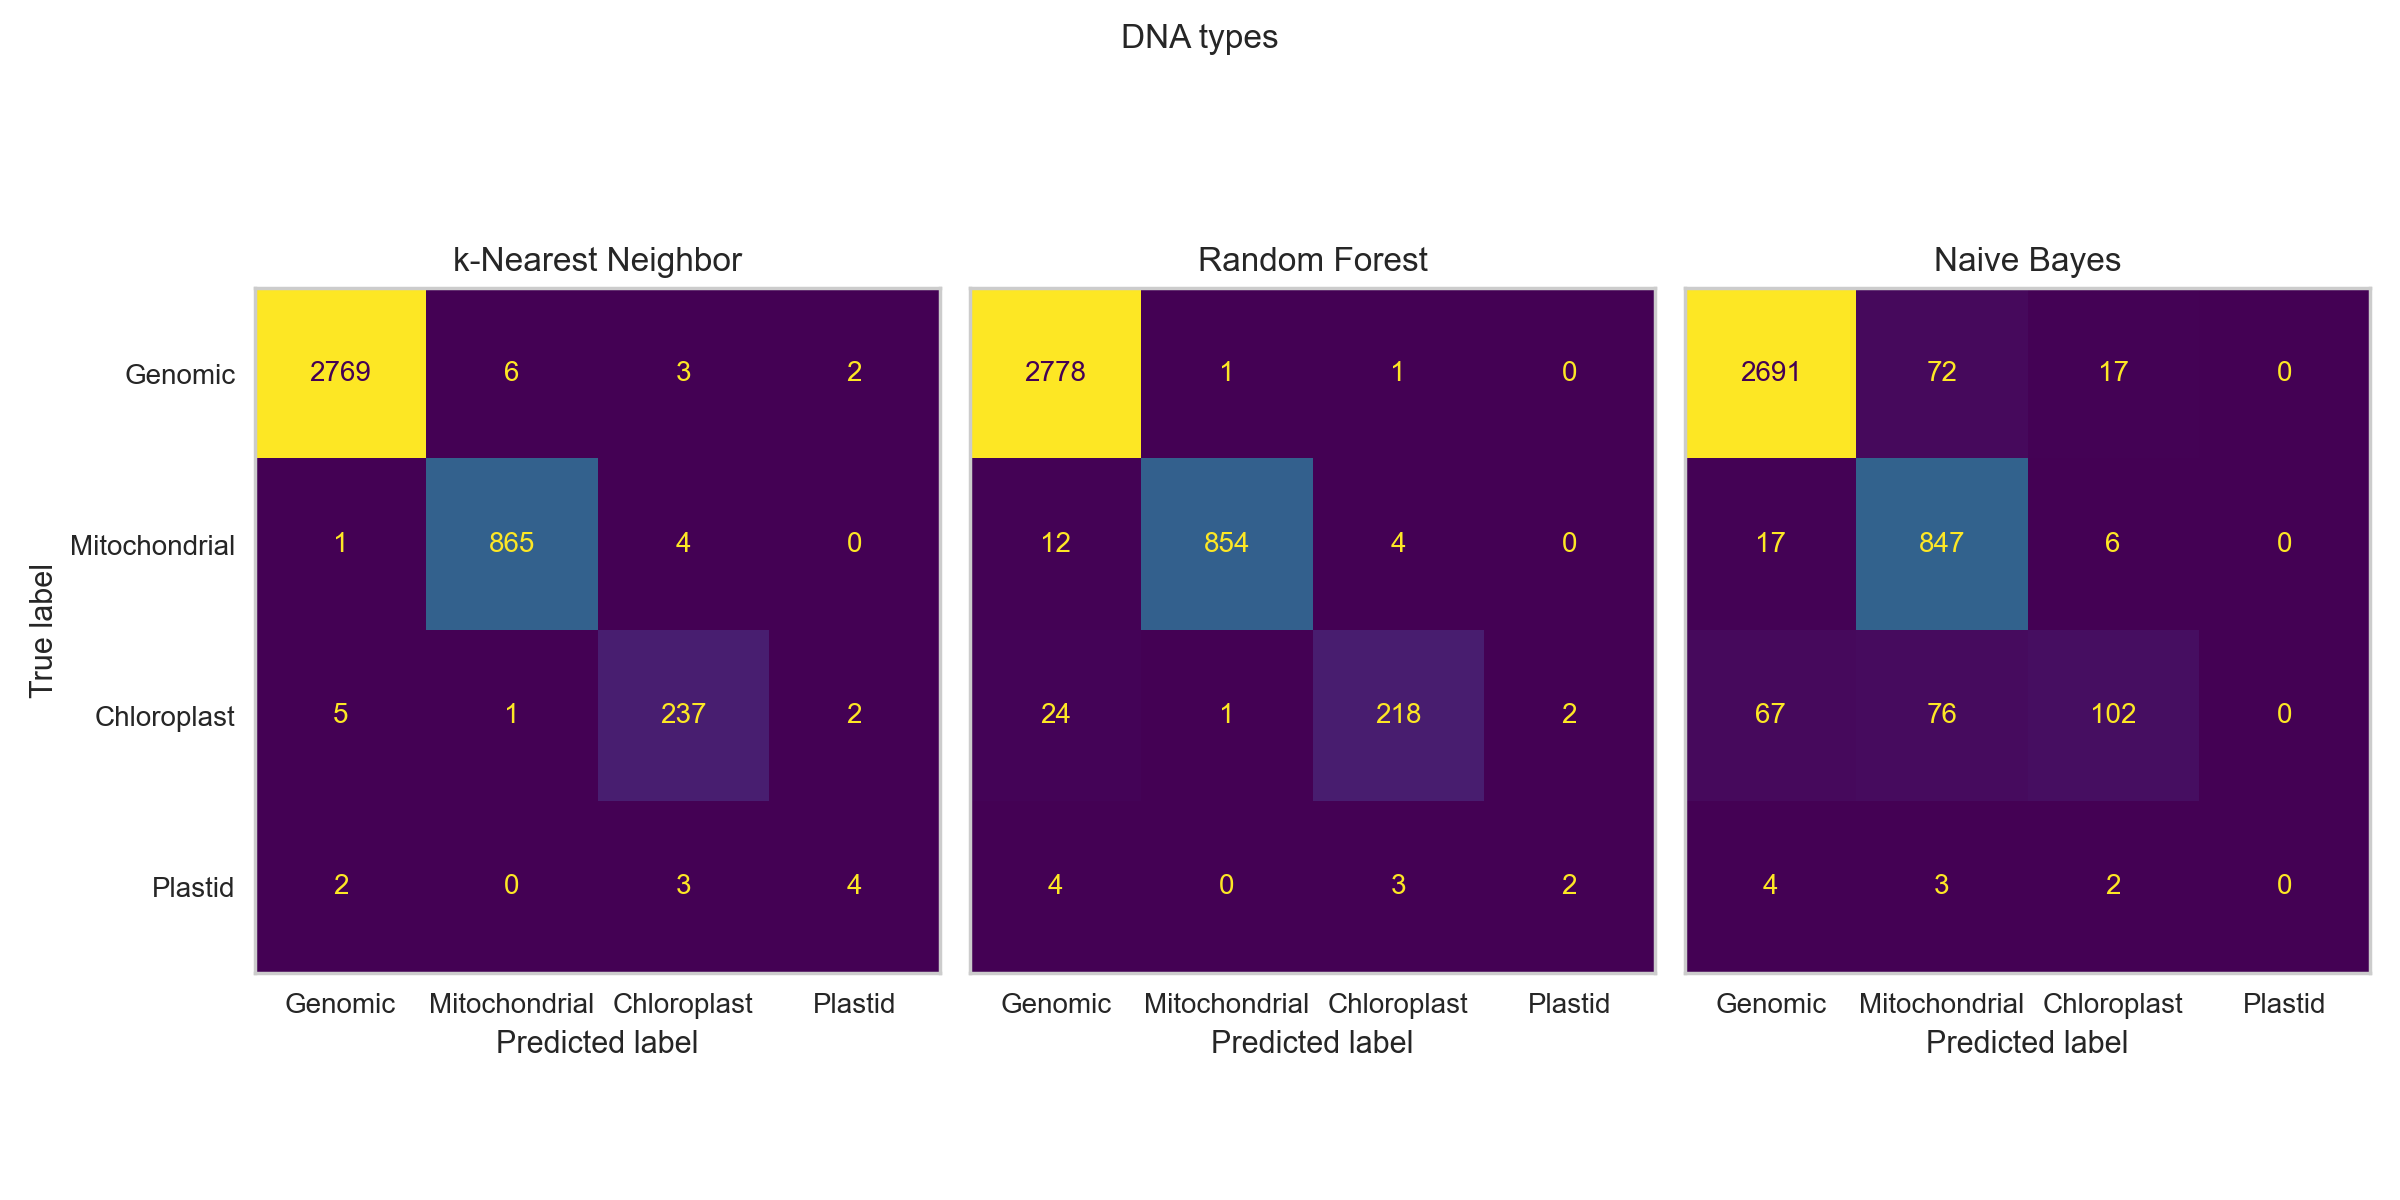

In [6]:
Image(filename="data/dna_plot.png")

---
<a id='data-prep'></a>

## 1. Data preparation

Similar to last time we must remove two invalid rows: 487 (SpeciesID: 12440) and 5064 (SpeciesID: 353569). Both have invalid data in the UUU and UUC column (column 5 and 6). There probably is a misplaced semicolon in the preceding SpeciesName column. Just to be safe both rows are dropped from the dataset and will not be included in any further analysis

In [7]:
data_raw = pd.read_csv("data/codon_usage.csv", sep=",")

C:\Users\hjano\AppData\Local\Temp\ipykernel_1728\3303151036.py:1: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  data_raw = pd.read_csv("data/codon_usage.csv", sep=",")


In [8]:
# I removed the steps to identify the invalid rows to make the code more concise
# The CSV indices start at 1, while pandas start 0
bad_rows = [
    data_raw[data_raw["UUU"] == "non-B hepatitis virus"].index[0] + 1,
    data_raw[data_raw["UUU"] == "12;I"].index[0] + 1,
]
data_raw = pd.read_csv("data/codon_usage.csv", sep=",", skiprows=bad_rows)

After dropping the two rows, the dataset contains 13.026 organisms with 69 attributes. The first two attributes are our labels: <b>Kingdom</b> and <b>DNAtype</b>. Next are the SpeciesID, Ncodons and SpeciesName, that provide additional information for the various organisms, but will not be used in our experiments. The last 64 attributes are the Codon frequencies.

In [9]:
data_raw.head()

,Kingdom,DNAtype,SpeciesID,Ncodons,SpeciesName,UUU,UUC,UUA,UUG,CUU,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
0,vrl,0,100217,1995,Epizootic haematopoietic necrosis virus,0.01654,0.01203,0.00050,0.00351,0.01203,...,0.00451,0.01303,0.03559,0.01003,0.04612,0.01203,0.04361,0.00251,0.00050,0.00000
1,vrl,0,100220,1474,Bohle iridovirus,0.02714,0.01357,0.00068,0.00678,0.00407,...,0.00136,0.01696,0.03596,0.01221,0.04545,0.01560,0.04410,0.00271,0.00068,0.00000
2,vrl,0,100755,4862,Sweet potato leaf curl virus,0.01974,0.02180,0.01357,0.01543,0.00782,...,0.00596,0.01974,0.02489,0.03126,0.02036,0.02242,0.02468,0.00391,0.00000,0.00144
3,vrl,0,100880,1915,Northern cereal mosaic virus,0.01775,0.02245,0.01619,0.00992,0.01567,...,0.00366,0.01410,0.01671,0.03760,0.01932,0.03029,0.03446,0.00261,0.00157,0.00000
4,vrl,0,100887,22831,Soil-borne cereal mosaic virus,0.02816,0.01371,0.00767,0.03679,0.01380,...,0.00604,0.01494,0.01734,0.04148,0.02483,0.03359,0.03679,0.00000,0.00044,0.00131


We have 11 different kingdoms.

In [10]:
kingdom = data_raw["Kingdom"]
np.sort(kingdom.unique()), kingdom.unique().size

(array(['arc', 'bct', 'inv', 'mam', 'phg', 'plm', 'pln', 'pri', 'rod',
        'vrl', 'vrt'], dtype=object),
 11)

And 11 different DNAtypes.

In [11]:
dnatype = data_raw["DNAtype"]
np.sort(dnatype.unique()), dnatype.unique().size

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 11, 12], dtype=int64), 11)

We will start with the <b>Kingdom</b> labels, because those had the best results with the ML models. Again we must transform them into a numerical representation.

In [12]:
data_king = data_raw.copy(deep=True)
condition = []
choices = []
# Setup conditions and choices
for count, key in enumerate(kingdom.unique()):
    condition.append(data_raw["Kingdom"] == key)  # unique kingdom 3-letter codes
    choices.append(count)  # integer now assigned to kingdom

data_king["Kingdom_num"] = np.select(condition, choices)

We define which label we will use and drop everything but the Codon frequencies and the numerical labels.

In [13]:
labels = ["Kingdom_num"]
complete_data = data_king.iloc[:, 5:]
targets = data_king.loc[:, labels]

---
<a id='parameters'></a>

## 2. Parameters

We define some global parameters. The number of features (n=64) defines the input size of our first layer and the number of classes (n=11) the output size of our output layer. The number of cores is used for the the data loaders.

In [14]:
# Parameters
feature_n = complete_data.drop(labels, axis=1).shape[1]  # Input_size
classes_n = len(targets.drop_duplicates(subset=labels))  # Output_size
num_epochs = 75
test_size = 0.3
val_size = 0.2
core_n = psutil.cpu_count(logical=False)
if core_n > 1:
    core_n = core_n - 1

---
<a id='split'></a>

## 3. Split Data

Other than last time the splitting strategy is different. Additionally to the train/test split, the train data is further split into train and validation data. The validation data is used during the training to find the best model.

In [15]:
DF_train_full, DF_test = train_test_split(
    complete_data,
    test_size=test_size,
    shuffle=True,
    random_state=RANDOM_SEED,
    stratify=targets,
)

In [16]:
DF_train, DF_val, = train_test_split(
    DF_train_full,
    test_size=val_size,
    shuffle=True,
    random_state=RANDOM_SEED,
    stratify=DF_train_full[labels],
)

After splitting the amount of samples in each set appears to have a reasonable size.

In [17]:
df_dict = {"train": DF_train, "val": DF_val, "test": DF_test}
for key, df_ in df_dict.items():
    print(f"{key}_data:\t size {df_.shape[0]:>3}")

train_data:	 size 7294
val_data:	 size 1824
test_data:	 size 3908


Looking at the class distribution we see the same problem as when doing the Machine Learning experiments. The dataset is highly imbalanced. Not only is the imbalance a problem, many classes also have very few samples. This could become a problem for Neural Network. Especially the classes 1, 3, 4, 9 and 10 have very few samples. But since our ML models were able to handle these highly underrepresented classes we will keep them in our dataset. 

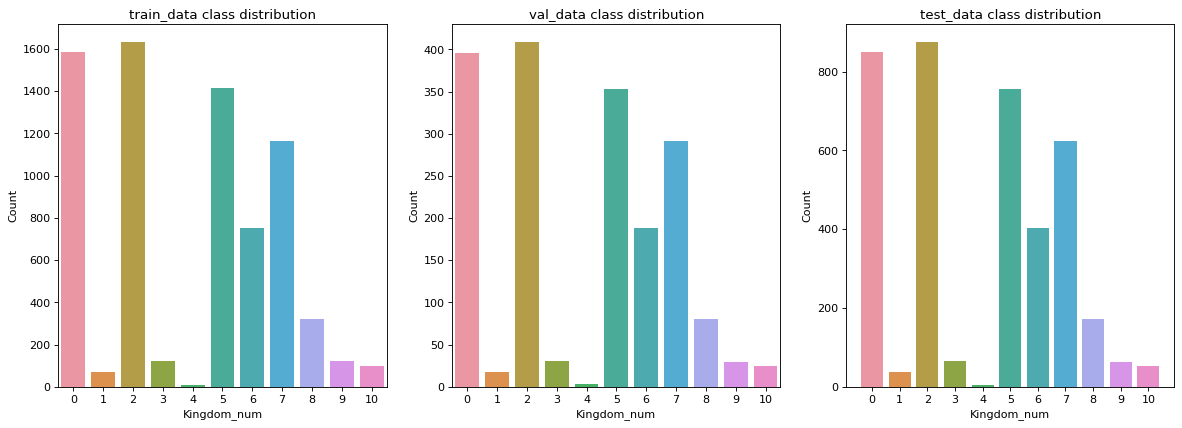

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=80)
for ax, (key, df_) in enumerate(df_dict.items()):
    sns.countplot(data=df_, x=labels[0], ax=axes[ax])
    axes[ax].set(title=f"{key}_data class distribution")
    axes[ax].set_ylabel("Count")
    plt.plot()

---
<a id='model-setup'></a>

## 4. Model setup and Hyperparameter Optimization
<a id='NN'></a>
### 4.1 Neural Network

As mentioned earlier we will use Pytorch Lightning for our Neural Network design. It divides our experiment into 3 distinct modules: the model, the datamodule and the trainer. The first module, the model, is very similar to the PyTorch approach. We start with a model that initializes the layers and has a forward method. Here we have designed the layer architecture in a way that it can be dynamically changed. The model always has one input- and output-layer, but the number of hidden layers can be changed. When adding a new hidden layer it is added behind the first layer and its input- and output-size changes by powers of two. An example is shown below.<br>
<img src='img/layer_architecture.svg' /><br>
If we would add another layer, it would appear in front of the other hidden layers with and inputsize of 256 and outputsize of 128. This model is then loaded into a Pytorch Lightning module. Inside this module we define our training, validation and test steps. Again the logic is similar to PyTorch, but instead of a for-loop we define specific methods (e.g. <code>training_step()</code>) that handle the calculation of the loss and logging of the various metrics. <br>
The second module is our data loader. This Pytorch Lightning Class combines the 3 different dataloaders into one class which is then given to our third and last module: the trainer. The trainer handles all the details of the training loop. It automatically enables/disables grads, runs the training, validation and test dataloaders, calls the callbacks at appropriate times and handles the computation on different devices.<br>
Everything is put together in the <code>train_codons()</code>-function below. Additionally a Tensorboard Logger and two callbacks are used. The first callback, ModelCheckpoint, observes the validation loss and saves the model with the lowest. The second, EarlyStopping, also observes the validation loss and stops the training loop should it no longer improve after x epochs. 

In [19]:
def train_codons(
    df_train,
    df_val,
    df_test,
    layer_count,
    lr,
    batch_size,
    num_epochs=10,
    core_n=1,
    weights=None,
    dev=False,
    cv=None,
    stop=15,
):
    pl.seed_everything(RANDOM_SEED, workers=True)
    if weights is not None:
        w_ind = True
    else:
        w_ind = False
    # DataModule
    data_module = DataModule(
        train_df=df_train,
        test_df=df_test,
        val_df=df_val,
        classes=labels,
        num_workers=core_n,
        batch_size=batch_size,
        device=device,
    )
    # Model
    model = NeuralNet(
        feature_n, classes_n, lr, layer_count=layer_count, weights=weights, device=device
    )
    # Callbacks
    logger = TensorBoardLogger(
        save_dir="logs",
        name="DL-Exam2",
        version=f"layer={layer_count}-lr={lr}-batchsize={batch_size}-cv={cv}-weights={w_ind}",
    )
    checkpoint_callback = ModelCheckpoint(
        filename="best-checkpoint",
        save_top_k=1,
        monitor="val_loss",
        mode="min",
    )
    stop_callback = EarlyStopping(monitor="val_loss", mode="min", verbose=False, patience=stop)
    callbacks = [checkpoint_callback, stop_callback]
    if device.type == "cuda":
        cuda_kwargs = {"accelerator": "gpu", "devices": 1}
    else:
        cuda_kwargs = dict()
    # Trainer
    trainer = pl.Trainer(
        max_epochs=num_epochs,
        logger=logger,
        log_every_n_steps=20,
        callbacks=callbacks,
        fast_dev_run=dev,  # If true, runs only 1 epoch/batch for testing
        enable_progress_bar=False,
        enable_model_summary=False,
        **cuda_kwargs,
    )
    trainer.fit(model, data_module)
    # End of Training loop

    params = {
        "hidden_layer": layer_count,
        "learning_rate": lr,
        "batch_size": batch_size,
        "fold": cv,
        "weights": w_ind,
    }
    if dev:
        return {**params}
    else:
        version = (
            f"layer={layer_count}-"
            f"lr={lr}-"
            f"batchsize={batch_size}-"
            f"cv={cv}-"
            f"weights={w_ind}"
        )
        ckpt_path = f"logs/DL-Exam2/{version}/checkpoints/best-checkpoint.ckpt"
        val_res = trainer.validate(datamodule=data_module, verbose=False, ckpt_path=ckpt_path)
        test_res = trainer.test(datamodule=data_module, verbose=False, ckpt_path=ckpt_path)

        return {**params, **val_res[0], **test_res[0]}

For the Hyperparameter (HP) optimization different approaches have been tested, but to ease the reproducibility on other devices a custom solution was chosen. But Pytorch Lightning is compatible with [Ray Tune](https://docs.ray.io/en/latest/tune/index.html) and Hyperparameter optimization was possible with Ray Tune.<br>
In our method four different HPs were optimized, the <b>number of hidden layers</b>, the <b>learning rate</b>, the <b>batch size</b> of the dataloaders, and whether <b>weights</b> were applied to the loss function. For each combination of HPs a model was trained the best combination chosen for the final models.

In [20]:
def hp_optimization(config, df_train, df_val, df_test, num_epochs, dev=False, cv=None, stop=15):
    runs = list()
    param_count = 0
    for zdx in range(len(config["hidden_layer"])):
        for xdx in range(len(config["learning_rate"])):
            for ydx in range(len(config["batch_size"])):
                for wdx in range(len(config["weights"])):
                    layer_count = config["hidden_layer"][zdx]
                    lr = config["learning_rate"][xdx]
                    batch_size = config["batch_size"][ydx]
                    weights = config["weights"][wdx]
                    start = timer()
                    runs.append(
                        train_codons(
                            df_train=df_train,
                            df_val=df_val,
                            df_test=df_test,
                            layer_count=layer_count,
                            lr=lr,
                            batch_size=batch_size,
                            num_epochs=num_epochs,
                            core_n=core_n,
                            weights=weights,
                            dev=dev,
                            cv=cv,
                            stop=stop,
                        )
                    )
                    param_count += 1
                    model_train_time = timer() - start
                    if weights is not None:
                        w_ind = True
                    else:
                        w_ind = False
                    print(
                        f"Finished training of the HP-combination: {param_count:02d} - fold: {cv}\n"
                        f"Trained on hidden layers: {layer_count:>2} learning-rate: {lr:.4f} batch-size: {batch_size:>3} weights:{w_ind}\n"
                        f"Training time: {str(timedelta(seconds=model_train_time))}"
                    )
    return runs

In [21]:
def combine_to_df(left_array, right_array, labels):
    df = pd.merge(
        pd.DataFrame(left_array).iloc[:, :-1],
        right_array.reset_index().drop(columns="index")[labels],
        left_index=True,
        right_index=True,
    )
    return df

<a id='CV'></a>
### 4.2 Cross-Validation

Before the final Hyperparameter optimization configuration used in this notebook, many more combinations were tested. All tested HP are listed below in the <code>pre_config</code> dictionary.

In [22]:
pre_config = {
    "hidden_layer": [2, 3, 4],
    "learning_rate": [1e-1, 1e-2, 1e-3, 1e-4],
    "batch_size": [32, 64, 128],
    "weights": [None, "king_weights_t"],
}

During those pre Hyperparameter optimizations some interesting insights could be gained. <br>
The first was that in the first runs the model did not learn. Changing the learning rate or letting it learn for more epochs did not affect the models ability to learn anything from the data. The problem here was that the data was not scaled. Although the Codon frequencies were in the preferable range of 0-1, most of them were close to zero. Also most of the highest values are around 0.1-0.2. And this is very plausible, with 64 possible Codons the average frequency is ~0.016. Scaling the data did increase the models ability to learn drastically.

In [23]:
complete_data.describe()

,UUU,UUC,UUA,UUG,CUU,CUC,CUA,CUG,AUU,AUC,...,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA,Kingdom_num
count,13026.000000,13026.000000,13026.000000,13026.000000,13026.000000,13026.000000,13026.000000,13026.000000,13026.000000,13026.000000,...,13026.000000,13026.000000,13026.000000,13026.000000,13026.000000,13026.000000,13026.000000,13026.000000,13026.000000,13026.000000
mean,0.024818,0.023440,0.020637,0.014104,0.017821,0.018287,0.019045,0.018452,0.028355,0.025038,...,0.009930,0.006423,0.024181,0.021164,0.028291,0.021683,0.001640,0.000590,0.006179,3.856211
std,0.017628,0.011598,0.020710,0.009280,0.010587,0.014573,0.024252,0.016578,0.017507,0.014596,...,0.008574,0.006388,0.013826,0.013039,0.014343,0.015019,0.001785,0.000882,0.010345,2.848169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.013910,0.015380,0.005610,0.007103,0.010890,0.007830,0.005302,0.007180,0.016370,0.015130,...,0.001690,0.001170,0.012390,0.011860,0.017360,0.009710,0.000560,0.000000,0.000410,2.000000
50%,0.021750,0.021905,0.015260,0.013360,0.016130,0.014560,0.009680,0.012800,0.025480,0.021540,...,0.009270,0.004545,0.025425,0.019070,0.026085,0.020540,0.001380,0.000420,0.001130,5.000000
75%,0.031308,0.029210,0.029495,0.019808,0.022730,0.025110,0.017255,0.024325,0.038117,0.031860,...,0.015928,0.010250,0.034190,0.027690,0.036800,0.031128,0.002370,0.000830,0.002890,6.000000
max,0.217300,0.091690,0.151330,0.101190,0.089780,0.100350,0.163920,0.107370,0.154060,0.088600,...,0.098830,0.058430,0.185660,0.113840,0.144890,0.158550,0.045200,0.025610,0.106700,10.000000


The next insight was that the number of <b>hidden layers</b> did not change the models performance noticeably. Although the number of learnable parameters increased from 7.000 to 90.000 the model performed very similar. Therefore the number of hidden layers was fixed to <b>3</b>. Maybe even more layers could have improved the models performance, but this was not further investigated.<br>
The third HP had a small influence on the model. Smaller batch sizes increased the rate with which the model learned. Also, because the smaller batch size resulted in more "erratic" learning steps, it had the possibility to move the model out of a local minimum. This was possible because, although in total the model was moving into the right direction, the small batches could force it to learn into the "wrong" direction and "escape" a local minimum. Therefore the <b>batch size</b> was fixed to <b>32</b>.<br>
The learning rate had the biggest influence on the models performance. Choosing a learning rate that was too high or too low prevented the model from successfully learning. The two <b>learning rates 0.01</b> and <b>0.001</b> showed the best results.<br>
Additionally to the learning rate, the weights also had a bigger influence on the model. Therefore both were kept for the final Hyperparameter optimization.

All those combinations can be observed in the Tensorboard below while the final models are training. Additionally, because all models with <i>weights</i> in their name use the EarlyStop callback, we can see in Tensorboard which Epoch was used as the best model. For that we must look at the last value in the epoch-metric.

## Tensorboard

In [24]:
%load_ext tensorboard
%tensorboard --logdir ./logs/ --host localhost

In [25]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

In [26]:
king_weights = compute_class_weight(
    class_weight="balanced",
    classes=targets.drop_duplicates(subset=labels).iloc[:, 0],
    y=targets.iloc[:, 0].ravel(),
)
king_weights_t = torch.Tensor(king_weights)

In the first Hyperparameter optimization runs the HPs have been optimized on the same train/validation/test split. This was a deliberate choice to reduce the required computational resources/time and to get a feeling for which HPs work and which do not work at all. But with our prefiltered set of HPs we will now use stratified k-Folds to combine the Hyperparameter optimization with a Cross-Validation setup. Again, to reduce the required computational resources/time, the Cross-Validation uses the same train/test split, but changes the train/validation splits.<br>

In [27]:
config = {
    "hidden_layer": [3],
    "learning_rate": [1e-2, 1e-3],
    "batch_size": [32],
    "weights": [None, king_weights_t],
}
runs_cv = list()
for idx, (train_index, val_index) in enumerate(
    skf.split(DF_train_full.drop(columns=labels), DF_train_full[labels])
):
    X_train, X_val = DF_train_full.iloc[train_index], DF_train_full.iloc[val_index]
    scaler = MinMaxScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_val_sc = scaler.transform(X_val)
    X_test_sc = scaler.transform(DF_test)  # Using initial DF_test because it stays the same

    DF_train_sc = combine_to_df(X_train_sc, X_train, labels)
    DF_val_sc = combine_to_df(X_val_sc, X_val, labels)
    DF_test_sc = combine_to_df(X_test_sc, DF_test, labels)
    runs_cv += hp_optimization(
        config,
        df_train=DF_train_sc,
        df_val=DF_val_sc,
        df_test=DF_test_sc,
        num_epochs=num_epochs,
        dev=True,  # Using Dev mode to show that the setup works
        cv=idx,
    )

C:\Users\hjano\OneDrive\Uni\Master\Vorlesungen\07_Deep_Learning\practical_exercises\.venv\lib\site-packages\pytorch_lightning\trainer\trainer.py:1933: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=20). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Finished training of the HP-combination: 01 - fold: 0
Trained on hidden layers:  3 learning-rate: 0.0100 batch-size:  32 weights:False
Training time: 0:00:24.882226
Finished training of the HP-combination: 02 - fold: 0
Trained on hidden layers:  3 learning-rate: 0.0100 batch-size:  32 weights:True
Training time: 0:00:24.211019
Finished training of the HP-combination: 03 - fold: 0
Trained on hidden layers:  3 learning-rate: 0.0010 batch-size:  32 weights:False
Training time: 0:00:24.420953
Finished training of the HP-combination: 04 - fold: 0
Trained on hidden layers:  3 learning-rate: 0.0010 batch-size:  32 weights:True
Training time: 0:00:23.124188


C:\Users\hjano\OneDrive\Uni\Master\Vorlesungen\07_Deep_Learning\practical_exercises\.venv\lib\site-packages\pytorch_lightning\trainer\trainer.py:1933: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=20). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Finished training of the HP-combination: 01 - fold: 1
Trained on hidden layers:  3 learning-rate: 0.0100 batch-size:  32 weights:False
Training time: 0:00:23.131429
Finished training of the HP-combination: 02 - fold: 1
Trained on hidden layers:  3 learning-rate: 0.0100 batch-size:  32 weights:True
Training time: 0:00:22.418100
Finished training of the HP-combination: 03 - fold: 1
Trained on hidden layers:  3 learning-rate: 0.0010 batch-size:  32 weights:False
Training time: 0:00:22.679764
Finished training of the HP-combination: 04 - fold: 1
Trained on hidden layers:  3 learning-rate: 0.0010 batch-size:  32 weights:True
Training time: 0:00:22.180447


C:\Users\hjano\OneDrive\Uni\Master\Vorlesungen\07_Deep_Learning\practical_exercises\.venv\lib\site-packages\pytorch_lightning\trainer\trainer.py:1933: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=20). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Finished training of the HP-combination: 01 - fold: 2
Trained on hidden layers:  3 learning-rate: 0.0100 batch-size:  32 weights:False
Training time: 0:00:22.725990
Finished training of the HP-combination: 02 - fold: 2
Trained on hidden layers:  3 learning-rate: 0.0100 batch-size:  32 weights:True
Training time: 0:00:22.132286
Finished training of the HP-combination: 03 - fold: 2
Trained on hidden layers:  3 learning-rate: 0.0010 batch-size:  32 weights:False
Training time: 0:00:24.782582
Finished training of the HP-combination: 04 - fold: 2
Trained on hidden layers:  3 learning-rate: 0.0010 batch-size:  32 weights:True
Training time: 0:00:23.564425


C:\Users\hjano\OneDrive\Uni\Master\Vorlesungen\07_Deep_Learning\practical_exercises\.venv\lib\site-packages\pytorch_lightning\trainer\trainer.py:1933: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=20). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Finished training of the HP-combination: 01 - fold: 3
Trained on hidden layers:  3 learning-rate: 0.0100 batch-size:  32 weights:False
Training time: 0:00:22.686362
Finished training of the HP-combination: 02 - fold: 3
Trained on hidden layers:  3 learning-rate: 0.0100 batch-size:  32 weights:True
Training time: 0:00:23.241368
Finished training of the HP-combination: 03 - fold: 3
Trained on hidden layers:  3 learning-rate: 0.0010 batch-size:  32 weights:False
Training time: 0:00:22.963106
Finished training of the HP-combination: 04 - fold: 3
Trained on hidden layers:  3 learning-rate: 0.0010 batch-size:  32 weights:True
Training time: 0:00:27.386884


C:\Users\hjano\OneDrive\Uni\Master\Vorlesungen\07_Deep_Learning\practical_exercises\.venv\lib\site-packages\pytorch_lightning\trainer\trainer.py:1933: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=20). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Finished training of the HP-combination: 01 - fold: 4
Trained on hidden layers:  3 learning-rate: 0.0100 batch-size:  32 weights:False
Training time: 0:00:25.050037
Finished training of the HP-combination: 02 - fold: 4
Trained on hidden layers:  3 learning-rate: 0.0100 batch-size:  32 weights:True
Training time: 0:00:22.760476
Finished training of the HP-combination: 03 - fold: 4
Trained on hidden layers:  3 learning-rate: 0.0010 batch-size:  32 weights:False
Training time: 0:00:26.078863
Finished training of the HP-combination: 04 - fold: 4
Trained on hidden layers:  3 learning-rate: 0.0010 batch-size:  32 weights:True
Training time: 0:00:23.009398


In [28]:
pd.DataFrame(runs_cv).head()

,hidden_layer,learning_rate,batch_size,fold,weights
0,3,0.010,32,0,False
1,3,0.010,32,0,True
2,3,0.001,32,0,False
3,3,0.001,32,0,True
4,3,0.010,32,1,False


The results of the Cross-Validation (CV) are 4 different combinations of HPs across 5 folds. Because each run takes ~30 minutes, the CV-Loop uses the dev mode. This is a Pytorch Lightning setting, which limits the training-loop to only 1 epoch to allow a quick debugging of model. The results of the full CV will be loaded from a previous run.

In [29]:
cv_hp_result_df = pd.read_parquet(path="data/cv_hp_optimization", engine="pyarrow")
cv_hp_results_mean = (
    cv_hp_result_df.groupby(["hidden_layer", "learning_rate", "batch_size", "weights"])
    .agg(["mean", "std"])
    .reset_index()
)
cv_hp_results_mean.iloc[:, :16]

hidden_layer learning_rate batch_size weights fold            val_loss  \
                                                mean       std      mean   
0            3         0.001         32   False  2.0  1.581139  0.304006   
1            3         0.001         32    True  2.0  1.581139  0.501618   
2            3         0.010         32   False  2.0  1.581139  0.323522   
3            3         0.010         32    True  2.0  1.581139  0.614015   

            val_accuracy           val_balanced_accuracy              val_f1  \
        std         mean       std                  mean       std      mean   
0  0.036682     0.909411  0.011134              0.815393  0.027893  0.802284   
1  0.056539     0.861813  0.014299              0.759732  0.025621  0.744256   
2  0.029136     0.902610  0.014038              0.802563  0.020342  0.785433   
3  0.072168     0.845579  0.017720              0.728503  0.030432  0.713392   

            val_precision            
        std          mean       std  
0  0.028575      0.809738  0.027174  
1  0.026383      0.758825  0.024218  
2  0.024720      0.791734  0.024969  
3  0.031517      0.733938  0.028813

After averaging over the 5 folds, we can see that the best Hyperparameter combination is:
- hidden_layer:  3
- learning rate: 0.001
- batch_size: 32
- weights: none

Interestingly using weights for the loss function decreased the models performance.

In [36]:
cv_hp_results_mean = (
    cv_hp_result_df.groupby(["hidden_layer", "learning_rate", "batch_size", "weights"])
    .mean()
    .reset_index()
)
best_params = cv_hp_results_mean[
    cv_hp_results_mean["val_balanced_accuracy"] == cv_hp_results_mean["val_balanced_accuracy"].max()
]
best_params.iloc[:, :9]

,hidden_layer,learning_rate,batch_size,weights,fold,val_loss,val_accuracy,val_balanced_accuracy,val_f1
0,3,0.001,32,False,2.0,0.304006,0.909411,0.815393,0.802284


---
<a id='eval'></a>

## 5. Model Evaluation
<a id='eval-king'></a>
### 5.1 Kingdom prediction

After the final Hyperparameter optimization we will use the same Cross-validation setup as before but this time change the train/test split to evaluate the performance of the model across different splits. We also increase the number of epochs to check if our model starts improving again after some time.

In [37]:
best_config = best_params.iloc[:1, :].to_dict("list")  # Load best HP from CV

In [38]:
# Parameters
feature_n = complete_data.drop(labels, axis=1).shape[1]
classes_n = len(targets.drop_duplicates(subset=labels))
num_epochs = 100  # Now using more epochs
test_size = 0.3
val_size = 0.2
core_n = psutil.cpu_count(logical=False)
if core_n > 1:
    core_n = core_n - 1

Because the result of our CV returns a boolean value for the weights, we must first change this value to None or the appropriate weights.

In [39]:
if best_params["weights"].iloc[0]:
    king_weights = compute_class_weight(
        class_weight="balanced",
        classes=targets.drop_duplicates(subset=labels).iloc[:, 0],
        y=targets.iloc[:, 0].ravel(),
    )
    best_config["weights"] = [torch.Tensor(king_weights)]
else:
    best_config["weights"] = [None]

In [40]:
skf_eval = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)

Now we perform the Cross-Validation over three different train/test splits.

In [41]:
runs_eval = list()
king_data = dict()
for idx, (train_index, test_index) in enumerate(
    skf_eval.split(complete_data.drop(columns=labels), complete_data[labels])
):
    X_train_full, X_test = complete_data.iloc[train_index], complete_data.iloc[test_index]
    X_train, X_val, = train_test_split(
        X_train_full,
        test_size=val_size,
        shuffle=True,
        random_state=RANDOM_SEED,
        stratify=X_train_full[labels],
    )
    scaler = MinMaxScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_val_sc = scaler.fit_transform(X_val)
    X_test_sc = scaler.transform(X_test)

    DF_train_sc = combine_to_df(X_train_sc, X_train, labels)
    DF_val_sc = combine_to_df(X_val_sc, X_val, labels)
    DF_test_sc = combine_to_df(X_test_sc, X_test, labels)
    runs_eval += hp_optimization(
        best_config,
        df_train=DF_train_sc,
        df_val=DF_val_sc,
        df_test=DF_test_sc,
        num_epochs=num_epochs,
        dev=True,  # Again for shorter evaluation
        cv=f"final_king_{idx}",
    )
    king_data[f"final_king_{idx}"] = [DF_train_sc, DF_val_sc, DF_test_sc]

C:\Users\hjano\OneDrive\Uni\Master\Vorlesungen\07_Deep_Learning\practical_exercises\.venv\lib\site-packages\pytorch_lightning\trainer\trainer.py:1933: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=20). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Finished training of the HP-combination: 01 - fold: final_king_0
Trained on hidden layers:  3 learning-rate: 0.0010 batch-size:  32 weights:False
Training time: 0:00:27.180632


C:\Users\hjano\OneDrive\Uni\Master\Vorlesungen\07_Deep_Learning\practical_exercises\.venv\lib\site-packages\pytorch_lightning\trainer\trainer.py:1933: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=20). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Finished training of the HP-combination: 01 - fold: final_king_1
Trained on hidden layers:  3 learning-rate: 0.0010 batch-size:  32 weights:False
Training time: 0:00:26.281828


C:\Users\hjano\OneDrive\Uni\Master\Vorlesungen\07_Deep_Learning\practical_exercises\.venv\lib\site-packages\pytorch_lightning\trainer\trainer.py:1933: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=20). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Finished training of the HP-combination: 01 - fold: final_king_2
Trained on hidden layers:  3 learning-rate: 0.0010 batch-size:  32 weights:False
Training time: 0:00:22.513092


In [42]:
pd.DataFrame(runs_eval).head()

,hidden_layer,learning_rate,batch_size,fold,weights
0,3,0.001,32,final_king_0,False
1,3,0.001,32,final_king_1,False
2,3,0.001,32,final_king_2,False


In [43]:
best_config = best_params.iloc[:1, :].to_dict("list")
eval_king_result = list()
for _model, _res in king_data.items():
    _best_model = load_best_model(
        best_config,
        NeuralNet,
        feature_n=feature_n,
        classes_n=classes_n,
        device=device,
        cv=_model,
    )
    eval_king_result.append(
        compute_metrics(
            _best_model,
            torch.tensor(_res[-1].drop(columns=labels).values, dtype=torch.float),
            _res[-1][labels],
        )
    )

In [44]:
eval_king_result_df = pd.DataFrame(eval_king_result)
eval_king_result_df

,Accuracy,Balanced Accuracy,ROC AUC,F1,Precision,confusion_matrix
0,0.8153,0.5562,0.9673,0.5547,0.6376,"[[773, 1, 48, 10, 0, 76, 34, 2, 0, 0, 0], [3, ..."
1,0.8356,0.5887,0.9682,0.5983,0.7324,"[[840, 0, 1, 0, 0, 20, 58, 22, 0, 0, 3], [13, ..."
2,0.6840,0.4010,0.9262,0.3704,0.5756,"[[659, 0, 3, 0, 0, 12, 90, 177, 2, 0, 0], [11,..."


The results of CV do not reflect 

In [45]:
eval_king_result_df.iloc[:, :-1].agg(["mean", "std"]).transpose()

,mean,std
Accuracy,0.778300,0.082295
Balanced Accuracy,0.515300,0.100312
ROC AUC,0.953900,0.023993
F1,0.507800,0.120972
Precision,0.648533,0.078970


Tensorboard also shows us, that increasing the number of epochs was not necessary, because the best epochs are 8, 21, and 27. After those epochs we can see how the training loss is still decreasing, but the validation loss starts to rise again. This is a clear indicator of overfitting. 

<a id='eval-dna'></a>
### 5.2 DNAtype prediction

After the evaluation of our Hyperparameter choice did not produce very satisfying results for the prediction of the Kingdom labels, we will use the same Hyperparameters and try to predict the DNA types instead. The reasoning behind this approach is, that although the evaluation on different train/test splits was not good, the previous Cross-Validation showed no big disturbances across the different folds. And since both targets use the same data, the Hyperparameters might still have good results with the DNAtype labels and spare as a second CV.

In [52]:
data_dna = data_raw.copy(deep=True)

Similar as the Kingdom labels the data is again highly imbalanced. But this time we have the additional problem of not enough samples. Not only is the data not enough for a neural network, we also do not have enough samples to perform all required splits. Therefore we will drop all but the classes 0, 1, 2 and 4.

In [53]:
data_dna["DNAtype_num"] = data_dna["DNAtype"]
data_dna.groupby("DNAtype_num").count()

,Kingdom,DNAtype,SpeciesID,Ncodons,SpeciesName,UUU,UUC,UUA,UUG,CUU,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
DNAtype_num,,,,,,,,,,,,,,,,,,,,,
0,9265,9265,9265,9265,9265,9265,9265,9265,9265,9265,...,9265,9265,9265,9265,9265,9265,9265,9265,9265,9265
1,2899,2899,2899,2899,2899,2899,2899,2899,2899,2899,...,2899,2899,2899,2899,2899,2899,2899,2899,2899,2899
2,816,816,816,816,816,816,816,816,816,816,...,816,816,816,816,816,816,816,816,816,816
3,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
4,31,31,31,31,31,31,31,31,31,31,...,31,31,31,31,31,31,31,31,31,31
5,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
6,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
7,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
9,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2


Like before with the data for the Kingdom labels, we drop all not required features and define the number of classes.

In [54]:
data_drop_dna = data_dna[data_dna["DNAtype"].isin([0, 1, 2, 4])]
labels = ["DNAtype_num"]
complete_data = data_drop_dna.iloc[:, 5:]
targets = data_drop_dna.loc[:, labels]
classes_n = len(targets.drop_duplicates(subset=labels))

In [55]:
DF_train_full, DF_test = train_test_split(
    complete_data,
    test_size=test_size,
    shuffle=True,
    random_state=RANDOM_SEED,
    stratify=targets,
)
DF_train, DF_val, = train_test_split(
    DF_train_full,
    test_size=val_size,
    shuffle=True,
    random_state=RANDOM_SEED,
    stratify=DF_train_full[labels],
)

Because we are using the same data, but now with different labels, the distribution in the train/validation/test splits is the same.

In [56]:
df_dict = {"train": DF_train, "val": DF_val, "test": DF_test}
for key, df_ in df_dict.items():
    print(f"{key}_data:\t size {df_.shape[0]:>3}")

train_data:	 size 7285
val_data:	 size 1822
test_data:	 size 3904


Again, the data is highly imbalanced. Especially class 4 is almost nonexistent. It also has the "wrong" label. Because our model uses the indices to predict the class, we must change the label to 3 and remove the gap. This change makes no difference for our analysis, but must be remembered when using this model in production.

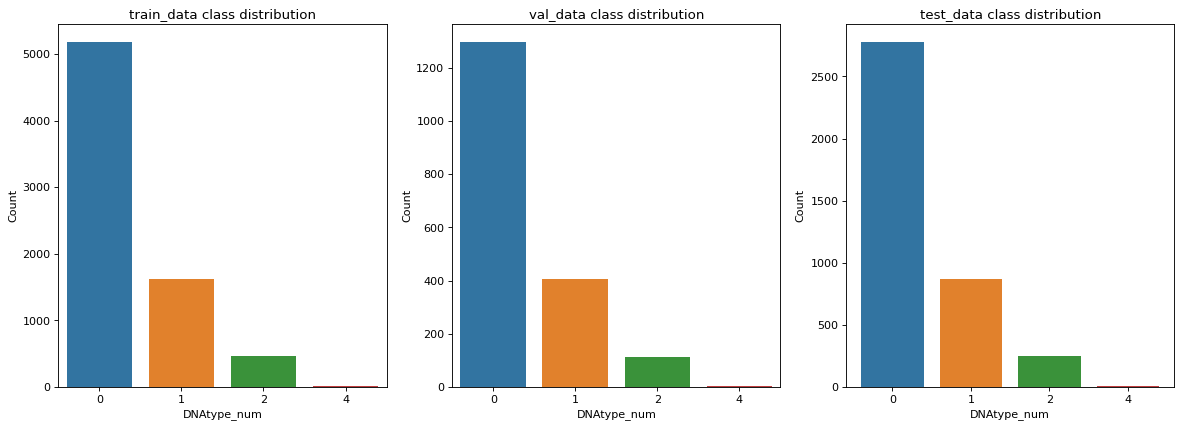

In [57]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=80)
for ax, (key, df_) in enumerate(df_dict.items()):
    sns.countplot(data=df_, x=labels[0], ax=axes[ax])
    axes[ax].set(title=f"{key}_data class distribution")
    axes[ax].set_ylabel("Count")
    plt.plot()

In [58]:
# Adjust labels
complete_data[labels] = np.where(complete_data[labels] == 4, 3, complete_data[labels])
targets = complete_data.loc[:, labels]

We use the same parameters as previously. We also use a higher number of epochs.

In [59]:
# Parameters
feature_n = complete_data.drop(labels, axis=1).shape[1]
classes_n = len(targets.drop_duplicates(subset=labels))  # Now 4 classes
num_epochs = 100  # Now using more epochs
test_size = 0.3
val_size = 0.2
core_n = psutil.cpu_count(logical=False)
if core_n > 1:
    core_n = core_n - 1

In [60]:
best_params

,hidden_layer,learning_rate,batch_size,weights,fold,val_loss,val_accuracy,val_balanced_accuracy,val_f1,val_precision,test_loss,test_accuracy,test_balanced_accuracy,test_f1,test_precision
0,3,0.001,32,False,2.0,0.304006,0.909411,0.815393,0.802284,0.809738,0.329518,0.90783,0.812485,0.801086,0.811714


In [61]:
if best_params["weights"].iloc[0]:
    dna_weights = compute_class_weight(
        class_weight="balanced",
        classes=targets.drop_duplicates(subset=labels).iloc[:, 0],
        y=targets.iloc[:, 0].ravel(),
    )
    best_config["weights"] = [torch.Tensor(dna_weights)]
else:
    best_config["weights"] = [None]

Here we also use the same setup as with the Kingdom labels. The only difference is the threshold for the EarlyStop callback. For this run we have increased it to 50, because in some previous runs the validation loss did decrease after our default value of 15 epochs.

In [62]:
runs_eval = list()
dna_data = dict()
for idx, (train_index, test_index) in enumerate(
    skf_eval.split(complete_data.drop(columns=labels), complete_data[labels])
):
    X_train_full, X_test = complete_data.iloc[train_index], complete_data.iloc[test_index]
    X_train, X_val, = train_test_split(
        X_train_full,
        test_size=val_size,
        shuffle=True,
        random_state=RANDOM_SEED,
        stratify=X_train_full[labels],
    )
    scaler = MinMaxScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_val_sc = scaler.fit_transform(X_val)
    X_test_sc = scaler.transform(X_test)

    DF_train_sc = combine_to_df(X_train_sc, X_train, labels)
    DF_val_sc = combine_to_df(X_val_sc, X_val, labels)
    DF_test_sc = combine_to_df(X_test_sc, X_test, labels)
    runs_eval += hp_optimization(
        best_config,
        df_train=DF_train_sc,
        df_val=DF_val_sc,
        df_test=DF_test_sc,
        num_epochs=num_epochs,
        dev=True,  # Again for shorter evaluation
        cv=f"final_dna_{idx}",
        stop=50,
    )
    dna_data[f"final_dna_{idx}"] = [DF_train_sc, DF_val_sc, DF_test_sc]

C:\Users\hjano\OneDrive\Uni\Master\Vorlesungen\07_Deep_Learning\practical_exercises\.venv\lib\site-packages\pytorch_lightning\trainer\trainer.py:1933: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=20). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Finished training of the HP-combination: 01 - fold: final_dna_0
Trained on hidden layers:  3 learning-rate: 0.0010 batch-size:  32 weights:False
Training time: 0:00:24.783728


C:\Users\hjano\OneDrive\Uni\Master\Vorlesungen\07_Deep_Learning\practical_exercises\.venv\lib\site-packages\pytorch_lightning\trainer\trainer.py:1933: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=20). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Finished training of the HP-combination: 01 - fold: final_dna_1
Trained on hidden layers:  3 learning-rate: 0.0010 batch-size:  32 weights:False
Training time: 0:00:22.609377


C:\Users\hjano\OneDrive\Uni\Master\Vorlesungen\07_Deep_Learning\practical_exercises\.venv\lib\site-packages\pytorch_lightning\trainer\trainer.py:1933: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=20). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Finished training of the HP-combination: 01 - fold: final_dna_2
Trained on hidden layers:  3 learning-rate: 0.0010 batch-size:  32 weights:False
Training time: 0:00:22.527210


In [63]:
pd.DataFrame(runs_eval).head()

,hidden_layer,learning_rate,batch_size,fold,weights
0,3,0.001,32,final_dna_0,False
1,3,0.001,32,final_dna_1,False
2,3,0.001,32,final_dna_2,False


In [64]:
best_config = best_params.iloc[:1, :].to_dict("list")
eval_dna_result = list()
for _model, _res in dna_data.items():
    _best_model = load_best_model(
        best_config,
        NeuralNet,
        feature_n=feature_n,
        classes_n=classes_n,
        device=device,
        cv=_model,
    )
    eval_dna_result.append(
        compute_metrics(
            _best_model,
            torch.tensor(_res[-1].drop(columns=labels).values, dtype=torch.float),
            _res[-1][labels],
        )
    )

In [65]:
eval_dna_result_df = pd.DataFrame(eval_dna_result)
eval_dna_result_df

,Accuracy,Balanced Accuracy,ROC AUC,F1,Precision,confusion_matrix
0,0.9308,0.6698,0.9711,0.5078,0.6712,"[[3082, 4, 0, 3], [6, 948, 0, 12], [6, 1, 0, 2..."
1,0.9343,0.7029,0.9757,0.5136,0.6748,"[[3081, 4, 0, 3], [3, 962, 0, 1], [3, 0, 0, 26..."
2,0.9320,0.6454,0.9523,0.5068,0.6682,"[[3086, 1, 0, 1], [16, 950, 0, 1], [28, 3, 0, ..."


The results of DNA type evaluation are much more promising. Not only is the Balanced Accuracy better than for the Kingdom labels, all three folds are very similar. This suggest that our trained model is very stable.

In [66]:
eval_dna_result_df.iloc[:, :-1].agg(["mean", "std"]).transpose()

,mean,std
Accuracy,0.932367,0.001779
Balanced Accuracy,0.672700,0.028859
ROC AUC,0.966367,0.012397
F1,0.509400,0.003672
Precision,0.671400,0.003305


Also, looking at Tensorboard we see that the additional epochs and higher threshold for the EarlyStop callback had no real effect. The best epochs are 11, 14, and 16.

---
<a id='result'></a>

## 6. Result
<a id='res-king'></a>
### 6.1 Kingdom

After the Hyperparameter optimization, Cross-Validation and model evaluation we will use the initial train/validation/test splits and train a final model and compare it to our baselines. The setup is the same as before.

In [77]:
labels = ["Kingdom_num"]
complete_data = data_king.iloc[:, 5:]
targets = data_king.loc[:, labels]
feature_n = complete_data.drop(labels, axis=1).shape[1]
classes_n = len(targets.drop_duplicates(subset=labels))
best_config["weights"] = [None]  # We know that no weights are better

DF_train_full, DF_test = train_test_split(
    complete_data,
    test_size=test_size,
    shuffle=True,
    random_state=RANDOM_SEED,
    stratify=targets,
)
DF_train, DF_val, = train_test_split(
    DF_train_full,
    test_size=val_size,
    shuffle=True,
    random_state=RANDOM_SEED,
    stratify=DF_train_full[labels],
)

scaler = MinMaxScaler()
X_train_sc = scaler.fit_transform(DF_train)
X_val_sc = scaler.fit_transform(DF_val)
X_test_sc = scaler.transform(DF_test)

DF_train_sc = combine_to_df(X_train_sc, DF_train, labels)
DF_val_sc = combine_to_df(X_val_sc, DF_val, labels)
DF_test_sc = combine_to_df(X_test_sc, DF_test, labels)
hp_res_king = hp_optimization(
    best_config,
    df_train=DF_train_sc,
    df_val=DF_val_sc,
    df_test=DF_test_sc,
    num_epochs=num_epochs,
    dev=False,
    cv=f"final_king",
    stop=50,
)

C:\Users\hjano\OneDrive\Uni\Master\Vorlesungen\07_Deep_Learning\practical_exercises\.venv\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:611: UserWarning: Checkpoint directory logs\DL-Exam2\layer=3-lr=0.001-batchsize=32-cv=final_king-weights=False\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
C:\Users\hjano\OneDrive\Uni\Master\Vorlesungen\07_Deep_Learning\practical_exercises\.venv\lib\site-packages\pytorch_lightning\trainer\trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000020AD13270D0>
Traceback (most recent call last):
  File "C:\Users\hjano\OneDrive\Uni\Master\Vorlesungen\07_Deep_Learning\practical_exercises\.venv\lib\site-packages\torch\utils\data\dataloader.py", line 1481, in __del__
    self._shutdo

Finished training of the HP-combination: 01 - fold: final_king
Trained on hidden layers:  3 learning-rate: 0.0010 batch-size:  32 weights:False
Training time: 0:00:34.374683


In [68]:
best_model_key = "final_king"
best_config = best_params.iloc[:1, :].to_dict("list")
best_model = load_best_model(
    best_config,
    NeuralNet,
    feature_n=feature_n,
    classes_n=classes_n,
    device=device,
    cv=best_model_key,
)
king_res = compute_metrics(
    best_model,
    torch.tensor(DF_test_sc.drop(columns=labels).values, dtype=torch.float),
    DF_test_sc[labels],
)

In [69]:
col_names = ["Model", "Accuracy", "Balanced Accuracy", "ROC AUC"]
king_combined = [
    ml_king.reset_index()[col_names],
    pd.DataFrame([{"Model": "Deep Learning", **king_res}])[col_names],
]
pd.concat(king_combined).set_index("Model")

,Accuracy,Balanced Accuracy,ROC AUC
Model,,,
k-Nearest Neighbor,1.0000,1.0000,1.0000
Random Forest,0.9660,0.7418,0.9979
Naive Bayes,0.5072,0.2369,0.8371
Deep Learning,0.8022,0.4583,0.9549


The Deep Learning model does perform better than Naive Bayes, but is outperformed by the other two ML models. The Balanced Accuracy of 0.4583 is not a good result. 

In [70]:
with open("data/ml_king_conf.p", "rb") as fp:
    ml_king_plot = pickle.load(fp)
ml_king_plot["Deep Learning"] = king_res["confusion_matrix"]
pop = ml_king_plot.pop("Naive Bayes")

Because the Naives Bayes model had such bad results, we remove it from the final Confusion Matrix. The Confusion Matrix does confirm what the metrics above already have told us. The Deep Learning model has a much harder time at predicting the Kingdom. As we have suspected earlier, the classes 1, 3, 4, 9 and 10 do pose a problem for the model. It almost does not predict any of those underrepresented classes. Additionally it has problems with some of the classes with more samples. Especially classes 0 and 5 have very disappointing results.

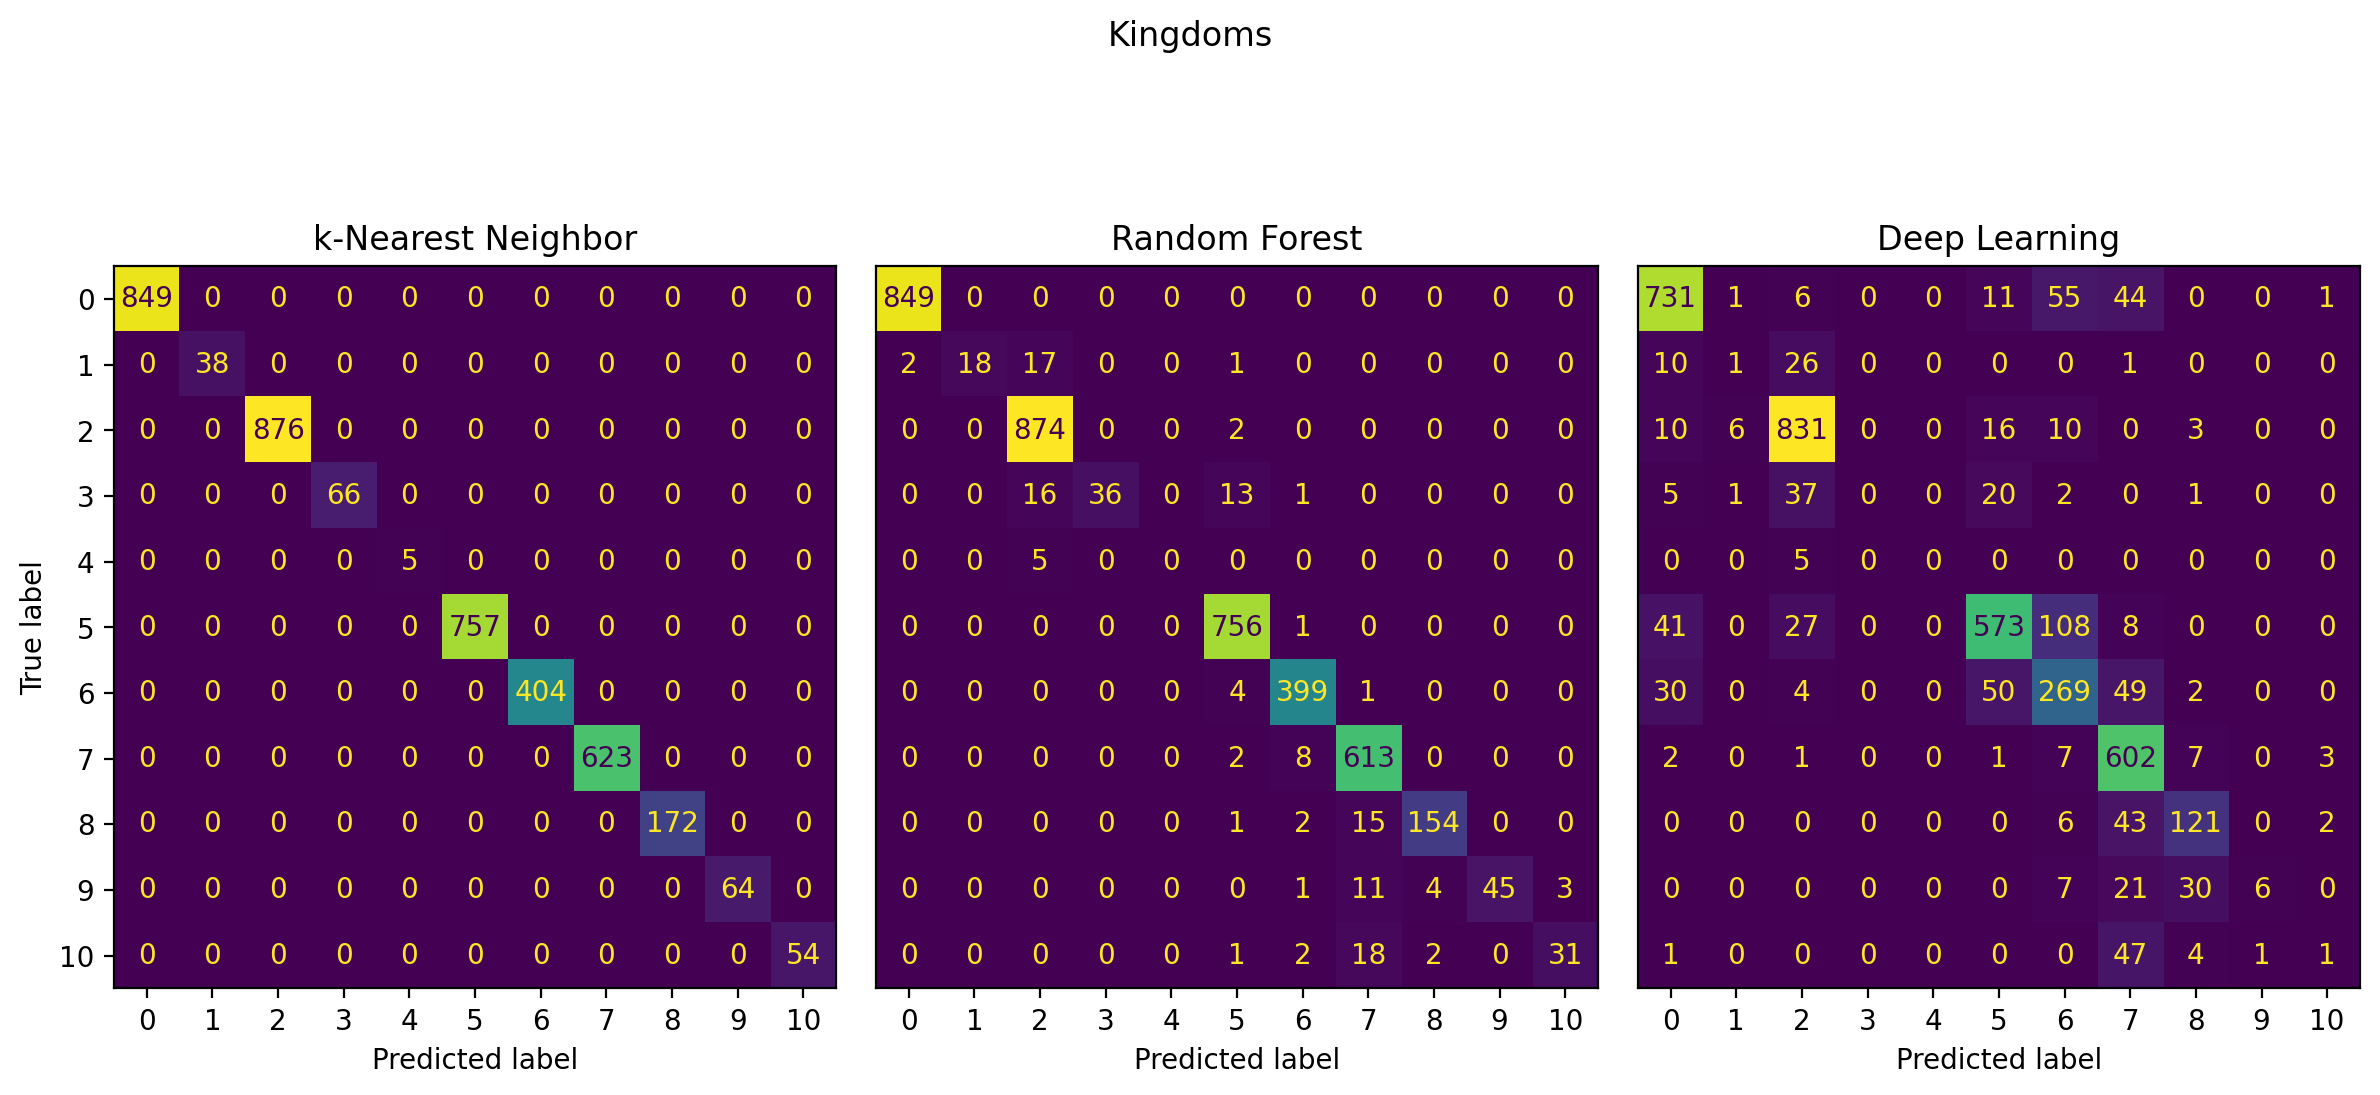

In [71]:
plot_multi_conf(ml_king_plot, targets.iloc[:, 0].unique(), "Kingdoms")

<a id='res-dna'></a>
### 6.2 DNAtype

After the Kingdom model has performed very poorly, we will examine the DNA model. Again the setup is the same.

In [81]:
labels = ["DNAtype_num"]
complete_data = data_drop_dna.iloc[:, 5:]
# Adjust labels
complete_data[labels] = np.where(complete_data[labels] == 4, 3, complete_data[labels])

targets = complete_data.loc[:, labels]
feature_n = complete_data.drop(labels, axis=1).shape[1]
classes_n = len(targets.drop_duplicates(subset=labels))  # Now 4 classes
best_config["weights"] = [None]

DF_train_full, DF_test = train_test_split(
    complete_data,
    test_size=test_size,
    shuffle=True,
    random_state=RANDOM_SEED,
    stratify=targets,
)
DF_train, DF_val, = train_test_split(
    DF_train_full,
    test_size=val_size,
    shuffle=True,
    random_state=RANDOM_SEED,
    stratify=DF_train_full[labels],
)

scaler = MinMaxScaler()
X_train_sc = scaler.fit_transform(DF_train)
X_val_sc = scaler.fit_transform(DF_val)
X_test_sc = scaler.transform(DF_test)

DF_train_sc = combine_to_df(X_train_sc, DF_train, labels)
DF_val_sc = combine_to_df(X_val_sc, DF_val, labels)
DF_test_sc = combine_to_df(X_test_sc, DF_test, labels)
hp_res_dna = hp_optimization(
    best_config,
    df_train=DF_train_sc,
    df_val=DF_val_sc,
    df_test=DF_test_sc,
    num_epochs=num_epochs,
    dev=False,
    cv=f"final_dna",
    stop=50,
)

In [82]:
best_model_key = "final_dna"
best_config = best_params.iloc[:1, :].to_dict("list")
best_model = load_best_model(
    best_config,
    NeuralNet,
    feature_n=feature_n,
    classes_n=classes_n,
    device=device,
    cv=best_model_key,
)
dna_res = compute_metrics(
    best_model,
    torch.tensor(DF_test_sc.drop(columns=labels).values, dtype=torch.float),
    DF_test_sc[labels],
)

In [83]:
dna_combined = [
    ml_dna.reset_index()[col_names],
    pd.DataFrame([{"Model": "Deep Learning", **dna_res}])[col_names],
]
pd.concat(dna_combined).set_index("Model")

,Accuracy,Balanced Accuracy,ROC AUC
Model,,,
k-Nearest Neighbor,0.9926,0.8505,0.9402
Random Forest,0.9867,0.7732,0.9679
Naive Bayes,0.9324,0.5895,0.9071
Deep Learning,0.9910,0.7888,0.9779


This time the DL model does perform much better. Not only does it beat the already bad Naive Bayes model, it also is an improvement over the Random Forest model. Unfortunately, it is outperformed the k-Nearest Neighbor. The Balanced Accuracy of 0.79 is worse the Balanced Accuracy of KNN with 0.85.

In [75]:
with open("data/ml_dna_conf.p", "rb") as fp:
    ml_dna_plot = pickle.load(fp)
ml_dna_plot["Deep Learning"] = dna_res["confusion_matrix"]
pop = ml_dna_plot.pop("Naive Bayes")

Again we ignore the Naive Bayes model in the Confusion Matrices. Looking at the DNA type predictions the Confusion Matrices are much harder to distinguish. Especially KNN and DL have very similar results with only single digit differences. DL is slightly better predicting Genomic DNA, while KNN is better at predicting the other three classes.

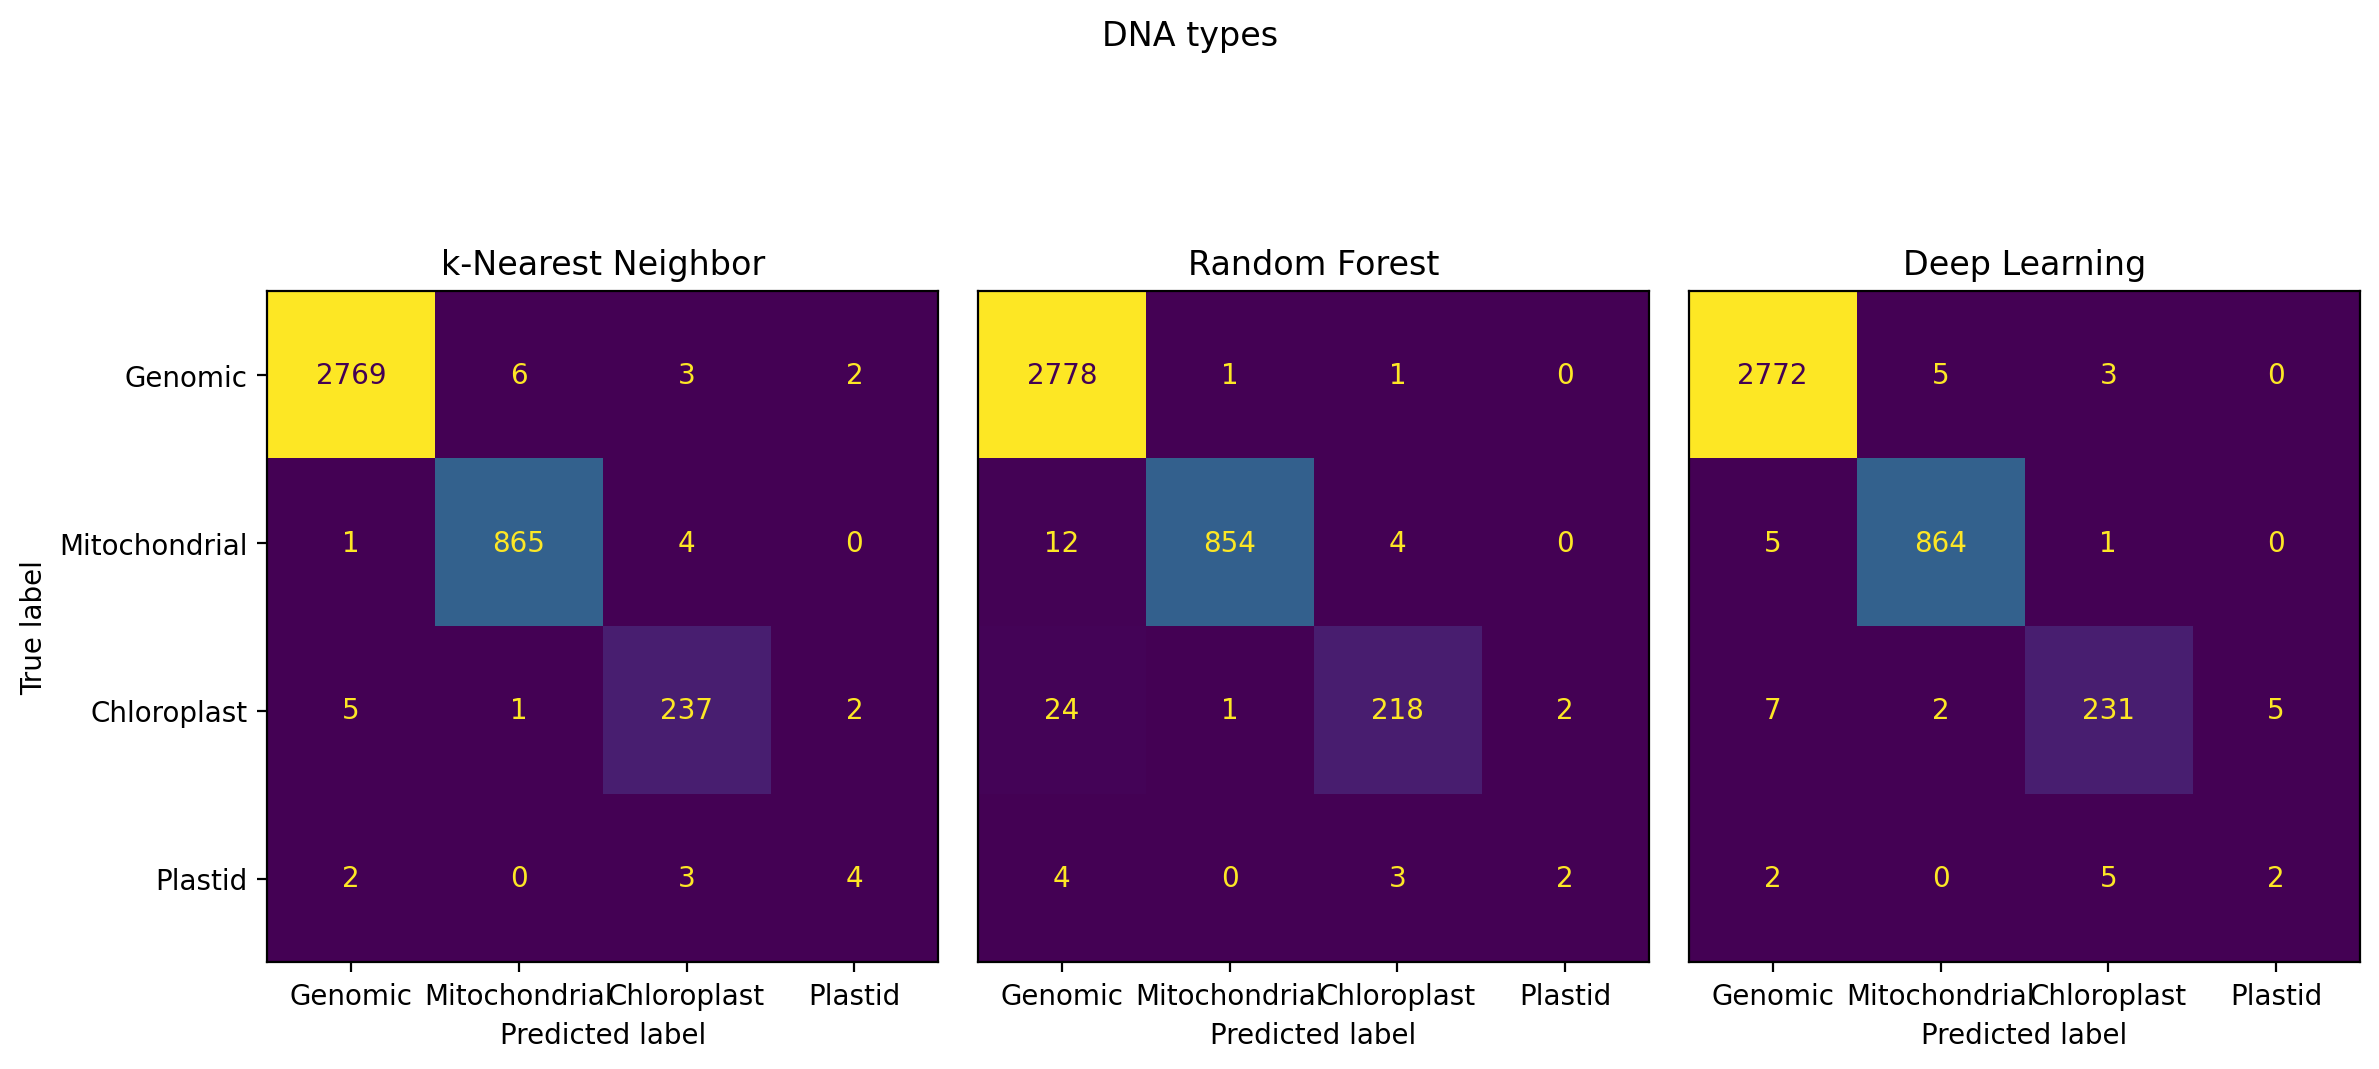

In [76]:
plot_multi_conf(ml_dna_plot, ["Genomic", "Mitochondrial", "Chloroplast", "Plastid"], "DNA types")

<a id='dis'></a>
### 6.3 Discussion

In the beginning we have asked the question if DL models can "outperform the classical Machine Learning models and where they might have some shortcomings". Especially the last question we have successfully answered. We have seen that performing extensive Hyperparameter optimization, Cross-Validation and using Models with tens of thousand trainable parameters does not guarantee better results than a simple Machine Learning setup using Random Forest or k-Nearest Neighbor. All models combined have taken around 36 hours of training time and still did not manage to beat KNN and RF for the Kingdom labels and KNN for the DNA labels. Not only have the DL models required more time, but they also needed much more code and customization. The classes with very few samples also presented an obstacle for the DL models.<br>
And still we were able to show that DL models can produce good results under the right circumstances. The final model for the DNA labels only needed 37 epochs to beat RF and had a very comparable performance to KNN. I am sure that more samples and a more sophisticated layer architecture can further improve the DL model. <br>
Finally, we have displayed that choosing the right label plays a very big role. Although the DL model had many problems with the Kingdom labels, it was much easier to predict the DNA type although both used the same underlying data. And though certainly the number of classes did play a role, in the final case the model was able to very accurately predict a class with only ~230 samples, while struggling before with classes with more than ~700 samples.

---
<a id='ref'></a>

## References

<p> [1] https://archive.ics.uci.edu/ml/datasets/Codon+usage

<p> [2] Khomtchouk BB: 'Codon usage bias levels predict taxonomic identity and genetic composition'. bioRxiv, 2020, doi: 10.1101/2020.10.26.356295.
    
<p> [3] Pytorch Lightning. https://www.pytorchlightning.ai/